# Caml API Usage

In [1]:
import os
import sys

os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

datasets = [
    "partially_linear_simple",
    "fully_heterogenous",
    "partially_linear_constant",
    "dowhy_linear",
]
backends = ["pandas", "pyspark", "polars"]

df_backend = backends[0]
dataset = datasets[3]

## Synthetic Data

In [2]:
from caml.extensions.synthetic_data import (
    make_partially_linear_dataset_simple,
    make_fully_heterogeneous_dataset,
    make_partially_linear_dataset_constant,
    make_dowhy_linear_dataset,
)

if dataset == "partially_linear_simple":
    df, true_cates, true_ate = make_partially_linear_dataset_simple(
        n_obs=5000,
        n_confounders=5,
        dim_heterogeneity=2,
        binary_treatment=True,
        seed=None,
    )
    df["true_cates"] = true_cates
elif dataset == "fully_heterogenous":
    df, true_cates, true_ate = make_fully_heterogeneous_dataset(
        n_obs=5000,
        n_confounders=50,
        theta=4.0,
        seed=None,
    )
    df["true_cates"] = true_cates
elif dataset == "partially_linear_constant":
    df, true_cates, true_ate = make_partially_linear_dataset_constant(
        n_obs=5000,
        ate=4.0,
        n_confounders=5,
        dgp="make_plr_CCDDHNR2018",  # make_plr_turrell2018
        seed=None,
    )
    df["true_cates"] = true_cates
elif dataset == "dowhy_linear":
    df, true_cates, true_ate = make_dowhy_linear_dataset(
        beta=2.0,
        n_obs=5000,
        n_confounders=8,
        n_discrete_confounders=0,
        n_effect_modifiers=10,
        n_discrete_effect_modifiers=0,
        n_treatments=1,
        binary_treatment=True,
        categorical_treatment=False,
        binary_outcome=False,
        seed=0,
    )

    for i in range(1, len(true_cates) + 1):
        if isinstance(true_cates[f"d{i}"], list):
            df[f"true_cate_d{i}_1"] = true_cates[f"d{i}"][0]
            df[f"true_cate_d{i}_2"] = true_cates[f"d{i}"][1]
        else:
            df[f"true_cate_d{i}"] = true_cates[f"d{i}"]


df["uuid"] = df.index

In [3]:
try:
    import polars as pl
    from pyspark.sql import SparkSession
except ImportError:
    pass

if df_backend == "polars":
    df = pl.from_pandas(df)
    spark = None
elif df_backend == "pandas":
    spark = None
    pass
elif df_backend == "pyspark":
    spark = (
        SparkSession.builder.master("local[1]")
        .appName("local-tests")
        .config("spark.executor.cores", "1")
        .config("spark.executor.instances", "1")
        .config("spark.sql.shuffle.partitions", "1")
        .getOrCreate()
    )
    df = spark.createDataFrame(df)

In [4]:
df

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,W2,W3,W4,W5,W6,W7,d1,y,true_cate_d1,uuid
0,-0.734174,0.746067,-0.514183,1.263472,1.618138,0.107801,0.728965,-0.617615,0.670827,0.446568,...,0.349570,1.544040,0.608347,0.413463,0.319038,1.117220,True,10.029198,7.895805,0
1,0.360291,-1.932914,0.355638,-0.447201,0.407519,0.634942,1.383042,1.956009,0.753676,1.185830,...,0.518594,-0.764329,-2.705680,0.945407,0.739611,0.041381,False,0.363335,4.205476,1
2,-0.104751,0.927280,1.256590,1.276506,-0.030499,-2.379054,0.938794,1.139509,0.865162,-0.254685,...,0.251285,-0.097417,1.380089,1.761147,0.030122,1.161709,True,7.666865,5.997871,2
3,0.154182,1.043003,-2.292409,0.925476,-1.047037,-0.549312,1.299322,1.616863,0.241936,-0.251244,...,-0.142385,0.246115,1.077600,1.494168,-0.512152,0.481243,True,2.799383,2.972327,3
4,-1.208678,0.240639,0.824865,-0.139602,-0.034174,-0.773827,0.293469,1.734268,-0.883983,0.722647,...,-1.500743,2.040542,-0.662343,-0.146286,-1.377621,1.561036,False,-0.365256,1.887710,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.448854,-1.375334,2.175952,0.672176,-0.228340,1.371068,0.884226,1.273376,-0.737275,0.114323,...,0.651367,1.697495,1.452603,-0.222843,-0.452726,1.546933,True,6.580873,4.486225,4995
4996,0.584021,0.102047,-1.912141,0.713642,-0.019364,-0.692769,-1.061701,0.362555,1.159278,0.728677,...,0.362476,2.000013,-0.348256,-0.357405,0.094475,0.314274,True,2.997520,1.228437,4996
4997,-0.773103,0.797999,2.151209,0.540746,-0.038906,1.814221,0.636068,-0.338612,-0.756731,1.957213,...,0.419666,1.116704,0.592782,0.639727,-0.384360,0.783123,True,8.953948,8.456594,4997
4998,-1.351807,1.186480,1.136243,1.212038,-0.308084,-1.415145,2.774491,-0.011797,1.884603,-0.172710,...,0.797566,-1.367433,1.858424,1.981646,0.075141,-0.440785,True,12.215302,10.337394,4998


## Core API

### CamlCATE

#### Class Instantiation

In [5]:
from caml import CamlCATE

caml = CamlCATE(
    df=df,
    Y="y",
    T="d1",
    X=[c for c in df.columns if "X" in c] + [c for c in df.columns if "W" in c],
    uuid="uuid",
    discrete_treatment=True,
    discrete_outcome=False,
    seed=0,
    verbose=1,
)

[09/15/24 16:12:36] INFO     Logging has been set up.                                                 ]8;id=363055;file:///caml/caml/logging.py\logging.py]8;;\:]8;id=957785;file:///caml/caml/logging.py#51\51]8;;\

In [6]:
print(caml)

================== CamlCATE Object ==================
Data Backend: pandas
No. of Observations: 5000
UUID: uuid
Outcome Variable: y
Discrete Outcome: False
Treatment Variable: d1
Discrete Treatment: True
Features/Confounders: ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'W0', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7']
Random Seed: 0



#### Nuissance Function AutoML

In [7]:
caml.auto_nuisance_functions(
    flaml_Y_kwargs={"time_budget": 10},
    flaml_T_kwargs={"time_budget": 10},
    use_ray=False,
    use_spark=False,
)

[flaml.automl.logger: 09-15 16:12:37] {1680} INFO - task = regression
[flaml.automl.logger: 09-15 16:12:37] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 09-15 16:12:37] {1789} INFO - Minimizing error metric: mse
[flaml.automl.logger: 09-15 16:12:37] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl.logger: 09-15 16:12:37] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 09-15 16:12:37] {2345} INFO - Estimated sufficient time budget=323s. Estimated necessary time budget=2s.
[flaml.automl.logger: 09-15 16:12:37] {2392} INFO -  at 0.0s,	estimator lgbm's best error=15.9858,	best estimator lgbm's best error=15.9858
[flaml.automl.logger: 09-15 16:12:37] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 09-15 16:12:37] {2392} INFO -  at 0.1s,	estimator lgbm's best error=15.4548,	best estimator lgbm's best error=15.4548
[flaml.automl.logger: 09-15 16:12:37] {2219} INFO -

#### Fit and ensemble CATE models

In [8]:
caml.fit_validator(
    subset_cate_models=[
        "LinearDML",
        "NonParamDML",
        "DML-Lasso3d",
        "CausalForestDML",
        "XLearner",
        "DomainAdaptationLearner",
        "SLearner",
        "TLearner",
        "DRLearner",
        "LinearDRLearner",
        "ForestDRLearner",
    ],
    rscorer_kwargs={},
    use_ray=False,
    ray_remote_func_options_kwargs={},
    sample_fraction=0.5,
    n_jobs=-1,
)

Pass `sample_weight` as keyword args.
The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.


[09/15/24 16:15:17] INFO     Ensemble Estimator RScore: 0.0760639206269591                             ]8;id=126464;file:///caml/caml/core/cate.py\cate.py]8;;\:]8;id=820385;file:///caml/caml/core/cate.py#1022\1022]8;;\

                    INFO     Inidividual Estimator RScores: {'LinearDML': 0.05589647571187628,         ]8;id=925850;file:///caml/caml/core/cate.py\cate.py]8;;\:]8;id=494419;file:///caml/caml/core/cate.py#1023\1023]8;;\
                             'DML-Lasso3d': 0.05034703751467662, 'CausalForestDML':                                
                             0.05356802547537487, 'XLearner': 0.06912311424176187,                                 
                             'DomainAdaptationLearner': 0.07010160770757634, 'SLearner':                           
                             0.0693030105561322, 'TLearner': 0.053635510145284226, 'DRLearner':                    
                             -0.09052708788385999, 'LinearDRLearner': 0.02803433910236597,                         
                             'ForestDRLearner': 0.06807417603331589, 'NonParamDML':                                
                             -0.4501329798013447}                                                                  

                    INFO     The ensemble estimator is the best estimator, filtering out models with   ]8;id=934491;file:///caml/caml/core/cate.py\cate.py]8;;\:]8;id=28178;file:///caml/caml/core/cate.py#1039\1039]8;;\
                             weights less than 0.01.                                                               

In [9]:
caml.validation_estimator

                    INFO     The validation estimator has been fit and will be returned.                ]8;id=952290;file:///caml/caml/core/_base.py\_base.py]8;;\:]8;id=150681;file:///caml/caml/core/_base.py#57\57]8;;\

#### CATE Validation

[09/15/24 16:18:55] INFO     All validation results suggest that the model has found statistically      ]8;id=724310;file:///caml/caml/core/cate.py\cate.py]8;;\:]8;id=121148;file:///caml/caml/core/cate.py#474\474]8;;\
                             significant heterogeneity.                                                            

   treatment  blp_est  blp_se  blp_pval  qini_est  qini_se  qini_pval  autoc_est  autoc_se  autoc_pval  cal_r_squared
0          1    1.272   0.043       0.0     0.821    0.047        0.0      2.385     0.163         0.0          0.789


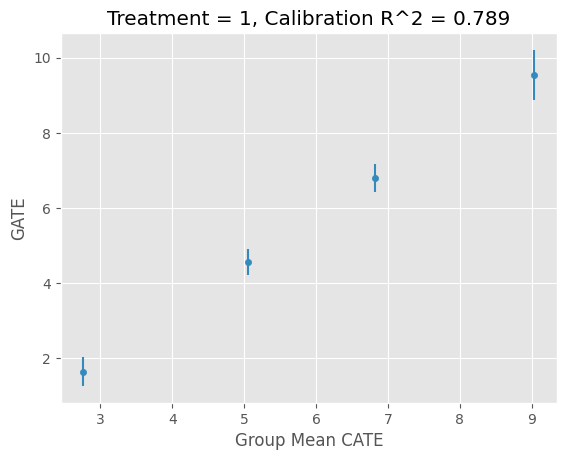

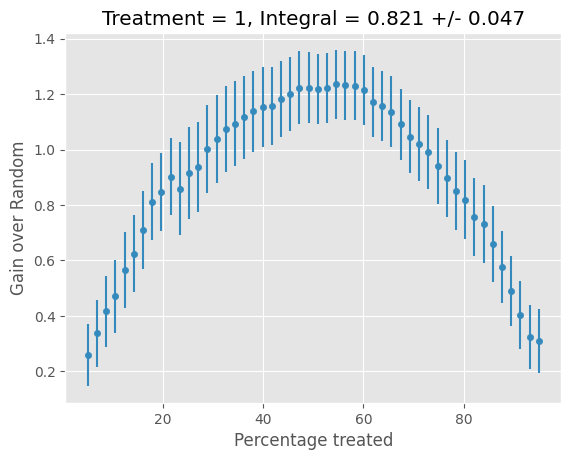

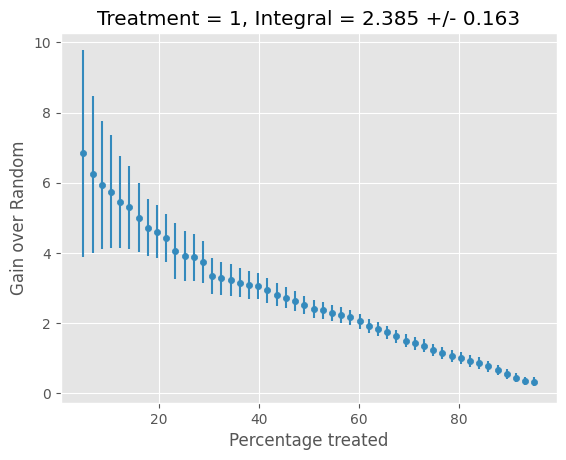

In [10]:
validation_results = caml.validate(estimator=None, print_full_report=True)

#### Refit best estimator on full dataset

In [11]:
caml.fit_final()

Pass `sample_weight` as keyword args.


In [12]:
caml.final_estimator

[09/15/24 16:21:56] INFO     The final estimator has been fit on the entire dataset and will be         ]8;id=901692;file:///caml/caml/core/_base.py\_base.py]8;;\:]8;id=131596;file:///caml/caml/core/_base.py#67\67]8;;\
                             returned.                                                                             

#### Predict CATEs

In [13]:
## "Out of sample" predictions

df_predictions = caml.predict(
    out_of_sample_df=df,
    out_of_sample_uuid="uuid",
    return_predictions=False,
    join_predictions=True,
)

if df_backend == "pyspark":
    df_predictions.show()
else:
    print(df_predictions)

            X0        X1        X2        X3        X4        X5        X6  \
0    -0.734174  0.746067 -0.514183  1.263472  1.618138  0.107801  0.728965   
1     0.360291 -1.932914  0.355638 -0.447201  0.407519  0.634942  1.383042   
2    -0.104751  0.927280  1.256590  1.276506 -0.030499 -2.379054  0.938794   
3     0.154182  1.043003 -2.292409  0.925476 -1.047037 -0.549312  1.299322   
4    -1.208678  0.240639  0.824865 -0.139602 -0.034174 -0.773827  0.293469   
...        ...       ...       ...       ...       ...       ...       ...   
4995  0.448854 -1.375334  2.175952  0.672176 -0.228340  1.371068  0.884226   
4996  0.584021  0.102047 -1.912141  0.713642 -0.019364 -0.692769 -1.061701   
4997 -0.773103  0.797999  2.151209  0.540746 -0.038906  1.814221  0.636068   
4998 -1.351807  1.186480  1.136243  1.212038 -0.308084 -1.415145  2.774491   
4999 -2.036969  0.840952 -1.485137 -0.388041 -1.194876  1.729826  1.111506   

            X7        X8        X9  ...        W3        W4    

In [14]:
## Append to internal dataframe

caml.predict(
    out_of_sample_df=None,
    out_of_sample_uuid=None,
    join_predictions=True,
    return_predictions=False,
)

caml.dataframe

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,W3,W4,W5,W6,W7,d1,y,true_cate_d1,uuid,cate_predictions_1
0,-0.734174,0.746067,-0.514183,1.263472,1.618138,0.107801,0.728965,-0.617615,0.670827,0.446568,...,1.544040,0.608347,0.413463,0.319038,1.117220,True,10.029198,7.895805,0,8.290128
1,0.360291,-1.932914,0.355638,-0.447201,0.407519,0.634942,1.383042,1.956009,0.753676,1.185830,...,-0.764329,-2.705680,0.945407,0.739611,0.041381,False,0.363335,4.205476,1,4.407450
2,-0.104751,0.927280,1.256590,1.276506,-0.030499,-2.379054,0.938794,1.139509,0.865162,-0.254685,...,-0.097417,1.380089,1.761147,0.030122,1.161709,True,7.666865,5.997871,2,6.932987
3,0.154182,1.043003,-2.292409,0.925476,-1.047037,-0.549312,1.299322,1.616863,0.241936,-0.251244,...,0.246115,1.077600,1.494168,-0.512152,0.481243,True,2.799383,2.972327,3,3.737290
4,-1.208678,0.240639,0.824865,-0.139602,-0.034174,-0.773827,0.293469,1.734268,-0.883983,0.722647,...,2.040542,-0.662343,-0.146286,-1.377621,1.561036,False,-0.365256,1.887710,4,2.514612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.448854,-1.375334,2.175952,0.672176,-0.228340,1.371068,0.884226,1.273376,-0.737275,0.114323,...,1.697495,1.452603,-0.222843,-0.452726,1.546933,True,6.580873,4.486225,4995,5.235600
4996,0.584021,0.102047,-1.912141,0.713642,-0.019364,-0.692769,-1.061701,0.362555,1.159278,0.728677,...,2.000013,-0.348256,-0.357405,0.094475,0.314274,True,2.997520,1.228437,4996,1.984560
4997,-0.773103,0.797999,2.151209,0.540746,-0.038906,1.814221,0.636068,-0.338612,-0.756731,1.957213,...,1.116704,0.592782,0.639727,-0.384360,0.783123,True,8.953948,8.456594,4997,8.114210
4998,-1.351807,1.186480,1.136243,1.212038,-0.308084,-1.415145,2.774491,-0.011797,1.884603,-0.172710,...,-1.367433,1.858424,1.981646,0.075141,-0.440785,True,12.215302,10.337394,4998,10.680888


#### CATE Rank Ordering

In [15]:
## "Out of sample" predictions

df_rank_ordered = caml.rank_order(
    out_of_sample_df=df_predictions,
    return_rank_order=False,
    join_rank_order=True,
    treatment_category=1,
)

df_rank_ordered

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,W4,W5,W6,W7,d1,y,true_cate_d1,uuid,cate_predictions_1,cate_ranking
0,0.223831,0.602957,1.768977,2.817188,1.954029,0.278708,2.642585,1.408145,2.406095,0.612914,...,-1.412346,0.962734,0.397905,1.147610,True,18.187834,17.304506,3473,15.636141,0
1,-0.154985,2.521677,0.291167,1.709774,2.130172,2.324639,1.730209,-0.109059,2.108190,-0.747208,...,-0.922322,1.232341,-0.538620,0.665964,True,17.155186,16.176518,4796,14.893120,1
2,-1.203017,0.146756,-0.077208,2.715830,1.017924,0.580591,2.893291,1.174426,2.957209,1.509573,...,-0.690597,2.670835,-0.901449,0.534872,True,16.654074,15.639545,1197,14.551938,2
3,1.040126,1.665786,3.511384,2.141895,2.201765,-0.080093,1.654775,-0.031891,0.637486,-0.722129,...,0.875938,0.356558,0.929042,0.923184,True,17.613892,14.928643,4721,13.995833,3
4,-0.106107,1.551081,1.223368,2.011217,0.251438,2.423944,1.133939,0.277103,1.961972,2.056966,...,-0.465361,0.276892,0.247468,2.231901,True,15.509183,15.365955,4188,13.872904,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.410592,-0.136321,-0.074024,-0.725525,-1.046776,0.142900,-1.074586,1.474928,-1.147419,-0.779667,...,-0.355681,1.630994,0.281232,-0.271490,True,-1.978776,-3.551286,1542,-2.305902,4995
4996,-2.161935,-2.327735,-0.717168,-0.772506,-1.852520,-0.512807,0.413928,0.546160,0.631342,-0.187765,...,0.717185,-0.565292,0.119649,0.445508,True,-2.400492,-4.259469,2385,-2.351653,4996
4997,-1.123164,-1.296084,0.230734,-0.610960,-1.372540,-1.504514,-0.905174,-0.549683,0.069375,0.559104,...,0.662107,0.493049,0.405721,0.713107,True,-3.112413,-4.015357,4033,-2.380812,4997
4998,-2.938489,-1.026672,-0.594926,-0.558139,-0.556555,-0.636909,-0.841222,0.393683,-0.554774,0.137736,...,-0.378897,-0.338168,-0.908551,1.569248,True,-2.338259,-4.109729,2181,-2.456903,4998


In [16]:
## Append to internal dataframe

caml.rank_order(
    out_of_sample_df=None,
    return_rank_order=False,
    join_rank_order=True,
    treatment_category=1,
)

caml.dataframe

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,W4,W5,W6,W7,d1,y,true_cate_d1,uuid,cate_predictions_1,cate_ranking
0,0.223831,0.602957,1.768977,2.817188,1.954029,0.278708,2.642585,1.408145,2.406095,0.612914,...,-1.412346,0.962734,0.397905,1.147610,True,18.187834,17.304506,3473,15.636141,0
1,-0.154985,2.521677,0.291167,1.709774,2.130172,2.324639,1.730209,-0.109059,2.108190,-0.747208,...,-0.922322,1.232341,-0.538620,0.665964,True,17.155186,16.176518,4796,14.893120,1
2,-1.203017,0.146756,-0.077208,2.715830,1.017924,0.580591,2.893291,1.174426,2.957209,1.509573,...,-0.690597,2.670835,-0.901449,0.534872,True,16.654074,15.639545,1197,14.551938,2
3,1.040126,1.665786,3.511384,2.141895,2.201765,-0.080093,1.654775,-0.031891,0.637486,-0.722129,...,0.875938,0.356558,0.929042,0.923184,True,17.613892,14.928643,4721,13.995833,3
4,-0.106107,1.551081,1.223368,2.011217,0.251438,2.423944,1.133939,0.277103,1.961972,2.056966,...,-0.465361,0.276892,0.247468,2.231901,True,15.509183,15.365955,4188,13.872904,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.410592,-0.136321,-0.074024,-0.725525,-1.046776,0.142900,-1.074586,1.474928,-1.147419,-0.779667,...,-0.355681,1.630994,0.281232,-0.271490,True,-1.978776,-3.551286,1542,-2.305902,4995
4996,-2.161935,-2.327735,-0.717168,-0.772506,-1.852520,-0.512807,0.413928,0.546160,0.631342,-0.187765,...,0.717185,-0.565292,0.119649,0.445508,True,-2.400492,-4.259469,2385,-2.351653,4996
4997,-1.123164,-1.296084,0.230734,-0.610960,-1.372540,-1.504514,-0.905174,-0.549683,0.069375,0.559104,...,0.662107,0.493049,0.405721,0.713107,True,-3.112413,-4.015357,4033,-2.380812,4997
4998,-2.938489,-1.026672,-0.594926,-0.558139,-0.556555,-0.636909,-0.841222,0.393683,-0.554774,0.137736,...,-0.378897,-0.338168,-0.908551,1.569248,True,-2.338259,-4.109729,2181,-2.456903,4998


#### CATE Visualization/Summary

In [17]:
cate_summary = caml.summarize(out_of_sample_df=df_rank_ordered, treatment_category=1)

cate_summary

,cate_mean,cate_sum,cate_std,cate_min,cate_max,count
0,5.909247,29546.233818,2.747814,-3.783207,15.636141,5000


In [18]:
cate_summary = caml.summarize(out_of_sample_df=None, treatment_category=1)

cate_summary

,cate_mean,cate_sum,cate_std,cate_min,cate_max,count
0,5.909247,29546.233818,2.747814,-3.783207,15.636141,5000


In [19]:
true_ate

{'d1': 5.5919416917657205}

#### Access my dataframe, estimator object, and get string representation of class

In [20]:
caml.dataframe

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,W4,W5,W6,W7,d1,y,true_cate_d1,uuid,cate_predictions_1,cate_ranking
0,0.223831,0.602957,1.768977,2.817188,1.954029,0.278708,2.642585,1.408145,2.406095,0.612914,...,-1.412346,0.962734,0.397905,1.147610,True,18.187834,17.304506,3473,15.636141,0
1,-0.154985,2.521677,0.291167,1.709774,2.130172,2.324639,1.730209,-0.109059,2.108190,-0.747208,...,-0.922322,1.232341,-0.538620,0.665964,True,17.155186,16.176518,4796,14.893120,1
2,-1.203017,0.146756,-0.077208,2.715830,1.017924,0.580591,2.893291,1.174426,2.957209,1.509573,...,-0.690597,2.670835,-0.901449,0.534872,True,16.654074,15.639545,1197,14.551938,2
3,1.040126,1.665786,3.511384,2.141895,2.201765,-0.080093,1.654775,-0.031891,0.637486,-0.722129,...,0.875938,0.356558,0.929042,0.923184,True,17.613892,14.928643,4721,13.995833,3
4,-0.106107,1.551081,1.223368,2.011217,0.251438,2.423944,1.133939,0.277103,1.961972,2.056966,...,-0.465361,0.276892,0.247468,2.231901,True,15.509183,15.365955,4188,13.872904,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.410592,-0.136321,-0.074024,-0.725525,-1.046776,0.142900,-1.074586,1.474928,-1.147419,-0.779667,...,-0.355681,1.630994,0.281232,-0.271490,True,-1.978776,-3.551286,1542,-2.305902,4995
4996,-2.161935,-2.327735,-0.717168,-0.772506,-1.852520,-0.512807,0.413928,0.546160,0.631342,-0.187765,...,0.717185,-0.565292,0.119649,0.445508,True,-2.400492,-4.259469,2385,-2.351653,4996
4997,-1.123164,-1.296084,0.230734,-0.610960,-1.372540,-1.504514,-0.905174,-0.549683,0.069375,0.559104,...,0.662107,0.493049,0.405721,0.713107,True,-3.112413,-4.015357,4033,-2.380812,4997
4998,-2.938489,-1.026672,-0.594926,-0.558139,-0.556555,-0.636909,-0.841222,0.393683,-0.554774,0.137736,...,-0.378897,-0.338168,-0.908551,1.569248,True,-2.338259,-4.109729,2181,-2.456903,4998


In [21]:
from econml.score import EnsembleCateEstimator

# Use this estimator object as pickled object for optimized inference
final_estimator = caml.final_estimator

if isinstance(final_estimator, EnsembleCateEstimator):
    for model in final_estimator._cate_models:
        print(model)
        print(model._input_names)
else:
    print(final_estimator)
    print(final_estimator._input_names)

[09/15/24 16:21:57] INFO     The final estimator has been fit on the entire dataset and will be         ]8;id=495367;file:///caml/caml/core/_base.py\_base.py]8;;\:]8;id=190755;file:///caml/caml/core/_base.py#67\67]8;;\
                             returned.                                                                             

{'feature_names': ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17'], 'output_names': ['Y0'], 'treatment_names': ['T0_True']}
{'feature_names': ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17'], 'output_names': ['Y0'], 'treatment_names': ['T0_True']}
{'feature_names': ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17'], 'output_names': ['Y0'], 'treatment_names': ['T0_True']}
{'feature_names': ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17'], 'output_names': ['Y0'], 'treatment_names': ['T0_True']}


In [22]:
print(caml)

================== CamlCATE Object ==================
Data Backend: pandas
No. of Observations: 5000
UUID: uuid
Outcome Variable: y
Discrete Outcome: False
Treatment Variable: d1
Discrete Treatment: True
Features/Confounders: ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'W0', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7']
Random Seed: 0
Nuissance Model Y_X: XGBRegressor(base_score=None, booster=None, callbacks=[],
             colsample_bylevel=0.7121653609234849, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.20522393251664733,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=6.080863634800954, missing=nan,


# Plots

In [23]:
from caml.extensions.plots import (cate_histogram_plot, 
                                   cate_true_vs_estimated_plot, 
                                   cate_line_plot)

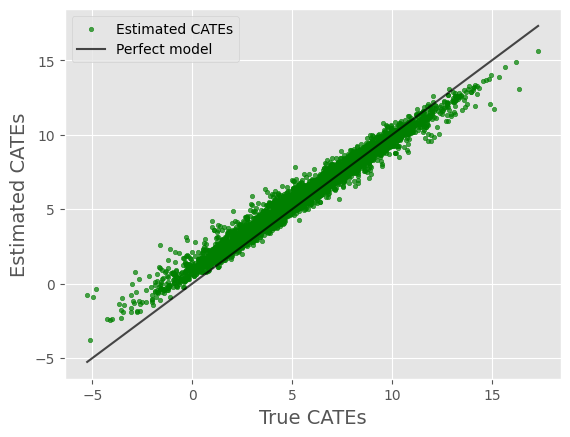

In [24]:
cate_true_vs_estimated_plot(true_cates=caml.dataframe['true_cate_d1'],estimated_cates=caml.dataframe['cate_predictions_1'])

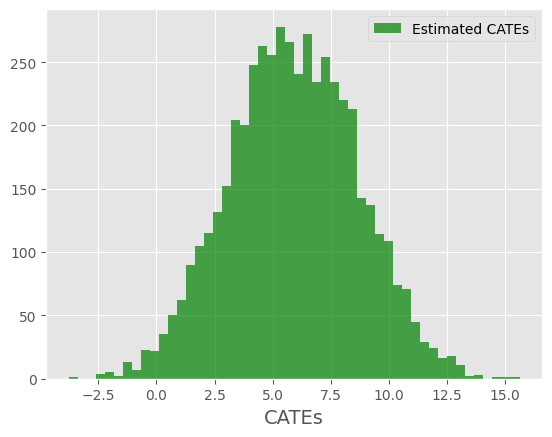

In [25]:
cate_histogram_plot(estimated_cates=caml.dataframe['cate_predictions_1'])

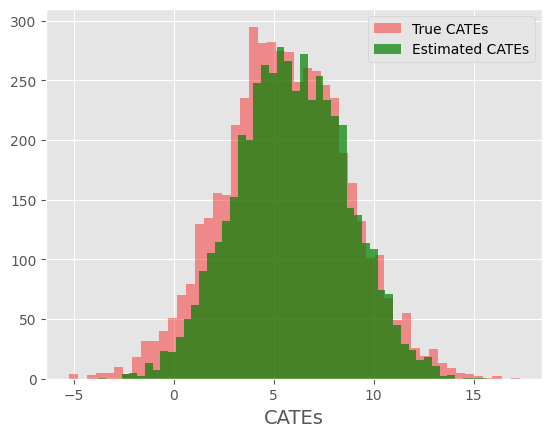

In [26]:
cate_histogram_plot(estimated_cates=caml.dataframe['cate_predictions_1'],true_cates=caml.dataframe['true_cate_d1'])

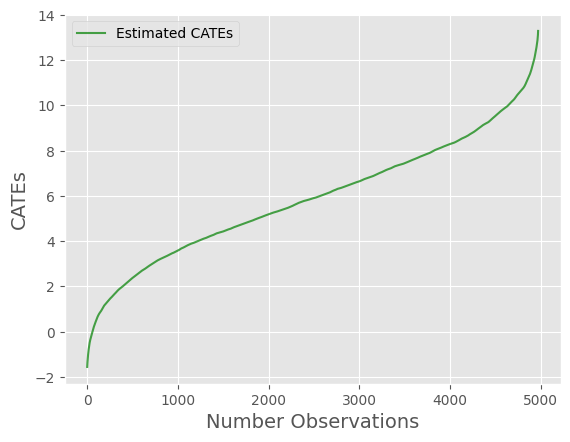

In [27]:
cate_line_plot(estimated_cates=caml.dataframe['cate_predictions_1'],window=30)

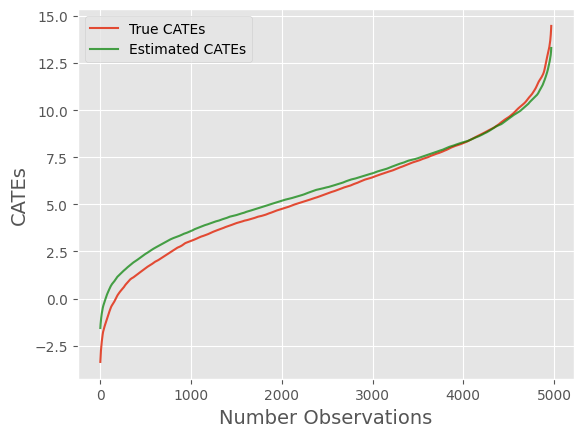

In [28]:
cate_line_plot(estimated_cates=caml.dataframe['cate_predictions_1'],true_cates=caml.dataframe['true_cate_d1'],window=30)